In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

%matplotlib inline

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


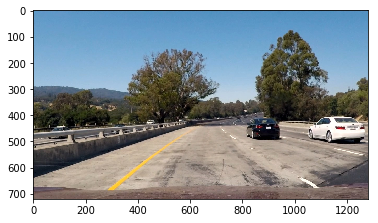

In [2]:
img = mpimg.imread("test_images/test1.jpg")
plt.imshow(img);

## Lane Finding

In [3]:
img_shape = (720, 1280)

def caliberate_camera(lst_img_path, nx, ny):
    lst_objpoints = []
    lst_imgpoints = []
    objpoints = np.zeros((nx*ny, 3), dtype=np.float32)
    objpoints[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    for img_path in lst_img_path:
        img = mpimg.imread(img_path)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            lst_objpoints.append(objpoints)
            lst_imgpoints.append(corners)
    ret, mat, dist, rvecs, tvecs = cv2.calibrateCamera(lst_objpoints, lst_imgpoints, img_size, None, None)
    return ret, mat, dist

lst_img_path = glob.glob("camera_cal/calibration*.jpg")
nx, ny = 9, 6
ret, mat, dist = caliberate_camera(lst_img_path, nx, ny)

def undistort(img_dist):
    return cv2.undistort(img_dist, mat, dist, None, mat)

def abs_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dx = 1 if orient=='x' else 0
    dy = 1 if orient=='y' else 0
    grad = cv2.Sobel(gray, cv2.CV_64F, dx, dy, None, ksize=sobel_kernel)
    scaled = np.uint8(255. * grad / grad.max())
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, None, ksize=sobel_kernel)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, None, ksize=sobel_kernel)
    mag = np.sqrt(gradx**2 + grady**2)
    scaled = np.uint8(255. * mag / mag.max())
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, None, ksize=sobel_kernel)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, None, ksize=sobel_kernel)
    abs_gradx = np.abs(gradx)
    abs_grady = np.abs(grady)
    dir = np.arctan2(abs_grady, abs_gradx)
    binary = np.zeros_like(dir, dtype=int)
    binary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary

def hls_thresh(img, channel='S', thresh=(0, 255)):
    if channel == 'H':
        ichannel = 0
    elif channel == 'L':
        ichannel = 1
    else:
        ichannel = 2
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_mono = img_hls[:, :, ichannel]
    scaled = np.uint8(255. * img_mono / img_mono.max())
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

def gray_thresh(img, thresh=(0, 255)):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    scaled = np.uint8(255. * img_gray / img_gray.max())
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

def binary_grad_filter(img):
    binary_gradx = abs_thresh(img, sobel_kernel=31, orient='x', thresh=(20, 40))
    binary_grady = abs_thresh(img, sobel_kernel=31, orient='y', thresh=(40, 80))
    binary_mag = mag_thresh(img, sobel_kernel=31, thresh=(40, 80))
    binary_dir = dir_thresh(img, sobel_kernel=1, thresh=(5*np.pi/12, 5*np.pi/12))
    binary_grad_filtered = binary_mag #(binary_grady | binary_gradx)# & binary_dir
    return binary_gradx

def binary_channel_filter(img):
    binary_H = hls_thresh(img, channel='H', thresh=(25, 30))
    binary_S = ~hls_thresh(img, channel='S', thresh=(0, 25))
    binary_gray = gray_thresh(img,  thresh=(200, 255))
    binary_channel_filtered = ((binary_H & binary_S) | binary_gray)
    return binary_channel_filtered

def filter(img):
    img_binary_grad_filtered = binary_grad_filter(img)
    img_binary_channel_filtered = binary_channel_filter(img)
    mask = np.ones_like(img_binary_channel_filtered)
    mask[600:720,550:850] = 0
    img_binary_filtered = np.uint8(255 * ((img_binary_grad_filtered | img_binary_channel_filtered) & mask))
    return img_binary_filtered

src = np.array([(100,720), (580,450), (700,450), (1180,720)], np.float32)
dst = np.array([(80,720), (80,0), (1200,0), (1200,720)], np.float32)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warp(img):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)

def unwarp(img_warped):
    return cv2.warpPerspective(img_warped, Minv, (img.shape[1], img.shape[0]))

def fit_polynomial(fitX, fitY, scaleY=720):
    Y2 = np.vstack([fitY**2, fitY]).T
    ridge = Ridge(alpha=100.0)
    try:
        ridge.fit(Y2, fitX)
        return np.concatenate((ridge.coef_, [ridge.intercept_]))
    except:
        return np.array([1., 1., 0.])

def pred_polynomial(predY, coeff, scaleY=720):
    Y3 = np.vstack([predY**2, predY, np.ones_like(predY)]).T
    try:
        predX = np.dot(Y3, coeff)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        predX = 1*predY**2 + 1*predY

    return predX

def fit_pred_polynomial(fitX, fitY, predY):
    coeff = fit_polynomial(fitX, fitY)
    return coeff, pred_polynomial(predY, coeff)

class Line():
    def __init__(self, thresh_min_samples=100, margin=50, gamma=0.1):
        self.detected = False
        self.undetected_count = 0
        self.thresh_min_samples = thresh_min_samples
        self.margin = margin
        self.gamma = gamma
        self._coeff = None
        self.default_coeff = np.array([1.0,1.0,0.0])
        self.detected = False
        
    def fit(self, binary_warped):
        x, y = self.find_lane_pixels(binary_warped)
        
        self.detected = len(x) >= self.thresh_min_samples
        prev_coeff = self._coeff
        
        self._coeff = fit_polynomial(x, y) if self.detected else prev_coeff
        if prev_coeff is not None:
            self._coeff = (1-self.gamma) * self._coeff + self.gamma * prev_coeff

        return self
            
    def pred(self, predY):
        predX = pred_polynomial(predY, self._coeff)
        return predX
    
    def find_lane_pixels(self, binary_warped):
        if self.detected:
            nonzero = binary_warped.nonzero()
            nonzerox = np.array(nonzero[1])
            nonzeroy = np.array(nonzero[0])
            polyx = pred_polynomial(nonzeroy, self._coeff)
            line_inds = (((polyx - self.margin) <= nonzerox) & (nonzerox < (polyx + self.margin))).nonzero()[0]
            x = nonzerox[line_inds]
            y = nonzeroy[line_inds]
        else:
            x, y = self._find_lane_pixels(binary_warped)
        return x, y
    
    def _find_lane_pixels(self, binary_warped):
        # print("_find_lane_pixels")
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        base = np.argmax(histogram)

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = self.margin
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated later for each window in nwindows
        current = base
        
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height

            ### Boundaries of the window ###
            win_x_low = current - margin
            win_x_high = current + margin

            ### Identify the nonzero pixels in x and y within the window ###
            good_inds = np.where(np.all([win_x_low <= nonzerox, nonzerox < win_x_high,
                win_y_low <= nonzeroy, nonzeroy < win_y_high], axis=0))[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            ### If found > minpix pixels, recenter next window on their mean position ###
            if len(good_inds) > minpix:
                current = np.mean(nonzerox[good_inds]).astype(int)

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]

        return x, y
    
    def _img_lookup_margin(self, binary_warped, predY):
        x, y = self._find_lane_pixels(binary_warped)
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Color in left and right line pixels
        out_img[y, x] = [255, 0, 0]
        predX = self.pred(predY)

        line_window1 = np.array([np.transpose(np.vstack([predX - self.margin, predY]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([predX + self.margin, predY])))])
        line_pts = np.hstack((line_window1, line_window2))

        # Draw the lane onto the warped blank image
        window_img = np.zeros_like(out_img)
        
        cv2.fillPoly(window_img, np.int_([line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        return result
    
ym_per_pix = 30./720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def rad_curv(A, B, y):
    Am = A * xm_per_pix / (ym_per_pix**2)
    Bm = B * xm_per_pix / ym_per_pix
    ym = y * ym_per_pix
    return np.power(1 + np.square(2*Am*ym + Bm), 1.5) / np.abs(2*Am)

# https://stackoverflow.com/questions/16615662/how-to-write-text-on-a-image-in-windows-using-python-opencv2
font = cv2.FONT_HERSHEY_SIMPLEX
topCenterCorner = (80,80)
topCenterCorner_nxtline = (80,160)
fontScale = 1.5
fontColor = (255,255,255)
lineType = 2

def caption(img, rad, dist, dir):
    cv2.putText(img,'Radius of Curvature = %.0f(m)'% rad, 
                topCenterCorner, font, fontScale, fontColor, lineType)
    cv2.putText(img,'Vehicle is %.2fm %s of center' % (dist, dir), 
                topCenterCorner_nxtline, font, fontScale, fontColor, lineType)


ploty = np.linspace(img_shape[1]//2, img_shape[1]-1, img_shape[1]//2)
def process_lanes(img, lane_left, line_right, debug=False):
    img_undist = undistort(img)
    img_shape = (img_undist.shape[1], img_undist.shape[0])

    x_mid = img_shape[0]//2
    img_binary_filtered = filter(img_undist)
    img_binary_warped = warp(img_binary_filtered)

    img_binary_warped_left = img_binary_warped[:,:x_mid]
    img_binary_warped_right = img_binary_warped[:,x_mid:]
    
    line_left.fit(img_binary_warped_left)
    line_right.fit(img_binary_warped_right)
    
    left_predx = line_left.pred(ploty)
    right_predx = line_right.pred(ploty)
    
    if debug:
        plt.imshow(img_binary_filtered, cmap='gray')
        plt.show()

        fig = plt.figure()

        fig.add_subplot(1, 2, 1)
        img_left_lookup_margin = line_left._img_lookup_margin(img_binary_warped_left, ploty)
        plt.imshow(img_left_lookup_margin)
        plt.plot(left_predx, ploty, color='yellow')
        plt.xlim(0, img_shape[0]//2)
        plt.ylim(img_shape[1], 0)

        fig.add_subplot(1, 2, 2)
        img_right_lookup_margin = line_right._img_lookup_margin(img_binary_warped_right, ploty)
        plt.imshow(img_right_lookup_margin)
        plt.plot(right_predx, ploty, color='yellow')
        plt.xlim(0, img_shape[0]//2)
        plt.ylim(img_shape[1], 0)
        plt.show()
    
    right_predx += x_mid
    
    # Add radius of curvature and distance from center
    left_rad = rad_curv(line_left._coeff[0], line_left._coeff[1], 720)
    right_rad = rad_curv(line_right._coeff[0], line_right._coeff[1], 720)
    rad = np.mean([left_rad, right_rad])

    mid_point = img_binary_warped.shape[1]//2
    lane_center = (left_predx[-1] + right_predx[-1]) // 2
    dir = "left" if lane_center < mid_point else "right"
    dist = np.abs(lane_center - mid_point) * xm_per_pix
    caption(img_undist, rad, dist, dir)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_binary_warped).astype(np.uint8)
    img_color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_predx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_predx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    # cv2.fillPoly(img_color_warp, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(img_color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(img_color_warp, Minv, img_shape) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    return result

## Vehicle Detection

In [4]:
def get_hog_features(img):
    assert img.shape[0] == 64
    return hog(img, block_norm='L2-Hys', feature_vector=False)

def get_spatial_features(img):
    assert img.shape == (64, 64, 3)
    return img.reshape(-1)

def get_hist_features(img, n_bins=12):
    assert img.shape == (64, 64, 3)    
    hist_r = np.histogram(img[:,:,0], bins=n_bins)[0]
    hist_g = np.histogram(img[:,:,1], bins=n_bins)[0]
    hist_b = np.histogram(img[:,:,2], bins=n_bins)[0]
    return np.concatenate([hist_r, hist_g, hist_b])

def predict_heatmap(img_orig):
    heatmap = np.zeros(img_orig.shape[:2], np.uint8)
    
    START_X, END_X = 400, 680
    START_Y, END_Y = 0, 1280
    
    img = img_orig[START_X: END_X, :, :]
    img = np.float32(1. * img / img.reshape(-1,3).max(axis=0))
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    WINDOW_SIZE_MIN = 64
    WINDOW_SIZE_MAX = END_X - START_X
    WINDOW_SIZE_STEP = 16
    
    PIXELS_PER_CELL = 8
    CELLS_PER_BLOCK = 3
    
    EPSILON = 1e-5
    
    IMG_CLF_SIZE = 64
    IMG_CLF_SHAPE = (IMG_CLF_SIZE, IMG_CLF_SIZE)

    # iterate over incrementally large slices of images from vehicles
    # further away, to those nearer to us
    lst_max = []
    lst_max2 = []
    for window_size in np.arange(WINDOW_SIZE_MIN, WINDOW_SIZE_MAX+1, WINDOW_SIZE_STEP):
        
        img_slice = img[:window_size, :]
        img_YCrCb_slice = img_YCrCb[:window_size, :]

        # re-scale image
        scaling_factor = 1.0 * IMG_CLF_SIZE / window_size
        img_scaled = cv2.resize(img_slice, (0,0), 
                                fx=scaling_factor, 
                                fy=scaling_factor)
        img_YCrCb_scaled = cv2.resize(img_YCrCb_slice, (0,0), 
                                      fx=scaling_factor, 
                                      fy=scaling_factor)

        # create hog feature, one-time for rescaled image-slice
        feat_hog_all = get_hog_features(img_YCrCb_scaled[:,:,0])

        # number of windows
        window_slide_step_y_scaled = int(1./3 * window_size * scaling_factor)
        n_window_y = (img_scaled.shape[1] - IMG_CLF_SIZE) // window_slide_step_y_scaled + 1

        for i in np.arange(n_window_y):
            window_start_x = 0
            window_end_x   = IMG_CLF_SIZE
            window_start_y = int(i * window_slide_step_y_scaled)
            window_end_y   = int(i * window_slide_step_y_scaled) + IMG_CLF_SIZE

            cells_per_window = IMG_CLF_SIZE // PIXELS_PER_CELL
            blocks_per_window = cells_per_window - CELLS_PER_BLOCK + 1
            cells_per_step = window_slide_step_y_scaled // PIXELS_PER_CELL
            blocks_per_step = cells_per_step - CELLS_PER_BLOCK + 1

            feat_hog = feat_hog_all[:blocks_per_window,
                                    (i*cells_per_step):(i*cells_per_step+blocks_per_window)]

            img_window = img_scaled[window_start_x:window_end_x, window_start_y:window_end_y]

            feat_spatial = img_window.reshape(-1)
            feat_hist = get_hist_features(img_window)

            img_scaled_with_window = np.copy(img_scaled)
            img_scaled_with_window = cv2.rectangle(img_scaled_with_window, 
                                                   (window_start_y, window_start_x), 
                                                   (window_end_y, window_end_x), (0,255,0), 4)

            feat = np.concatenate((feat_spatial, feat_hist, feat_hog.reshape(-1)))

            if clf.predict(feat[np.newaxis,:]) == 1:
                window_unscaled_start_x = int(window_start_x / scaling_factor)
                window_unscaled_end_x = int(window_end_x / scaling_factor)

                window_unscaled_start_y = int(window_start_y / scaling_factor)
                window_unscaled_end_y = int(window_end_y / scaling_factor)

                heatmap[START_X+window_unscaled_start_x:START_X+window_unscaled_end_x, 
                         START_Y+window_unscaled_start_y:START_Y+window_unscaled_end_y] += 1
                    
    img_pred = 1. * heatmap / heatmap.max()
    img_pred = np.dstack((img_pred, np.zeros_like(img_pred), np.zeros_like(img_pred)))
    return heatmap, img_pred

def apply_threshold(heatmap, thresh):
    heatmap = heatmap.copy()
    heatmap[heatmap <= thresh] = 0
    return heatmap

def height(pt1, pt2):
    return  pt2[1] - pt1[1]

def width(pt1, pt2):
    return pt2[0] - pt1[0]

In [5]:
clf = joblib.load("model/clf_ycrcb.jbl")

In [6]:
THRESH = 5

line_left = Line()
line_right = Line()

def predict(img):
    img_undist = undistort(img)
    heatmap, img_pred = predict_heatmap(img)
    img_thresh = apply_threshold(heatmap, THRESH)
    
    img_result = img_undist #process_lanes(img, line_left, line_right)
    
    labels = label(img_thresh)
    img_pred2 = np.zeros_like(img)
    
    for i, car_number in enumerate(range(1, labels[1]+1)):
        nonzero = (labels[0] == car_number).nonzero()
        nonzerox = np.array(nonzero[0])
        nonzeroy = np.array(nonzero[1])

        if nonzerox.shape[0] > 0:
            pt1 = (np.min(nonzeroy), np.min(nonzerox))
            pt2 = (np.max(nonzeroy), np.max(nonzerox))

            bbox_height = height(pt1, pt2)
            bbox_width = width(pt1, pt2)

            if (0.5 * bbox_height) <= bbox_width <= (2.0 * bbox_width):
                img_result = cv2.rectangle(img_result, pt1, pt2, (0,0,255), 6)
                img_pred2[pt1[1]:pt2[1],pt1[0]:pt2[0],i-1] = 255 * img_pred[pt1[1]:pt2[1],pt1[0]:pt2[0],0]
    
    return img_result, img_pred, img_pred2

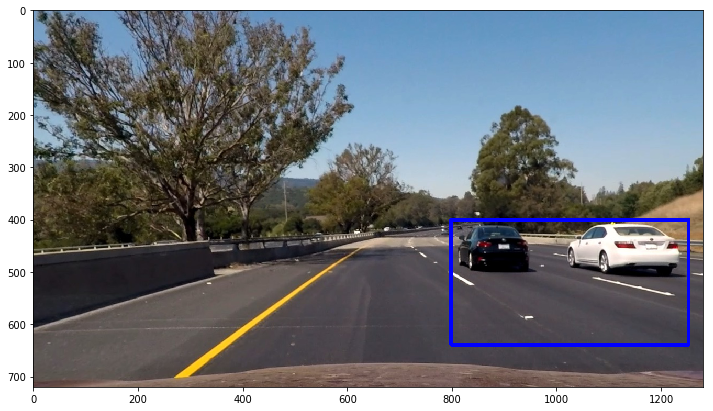

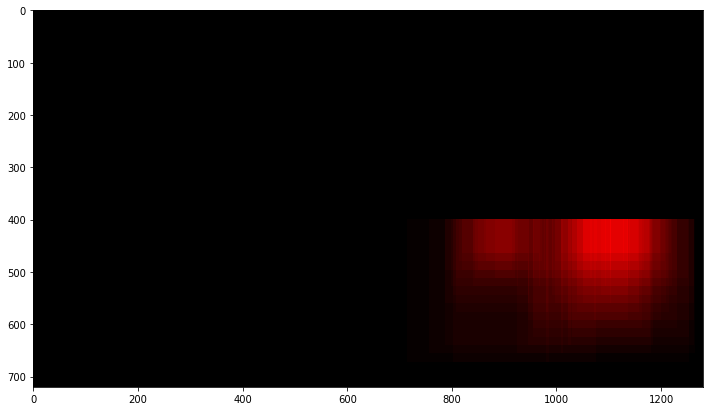

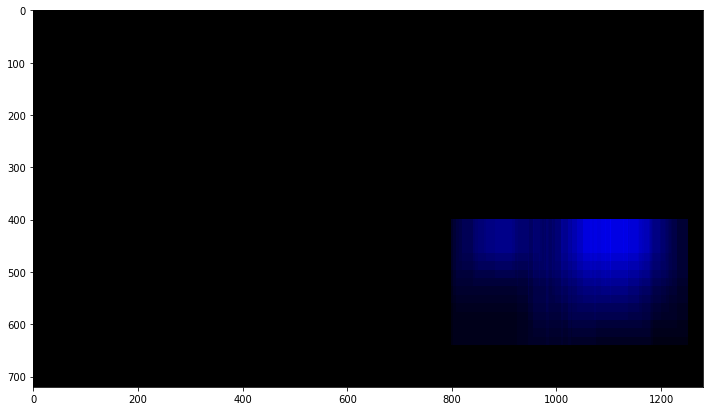

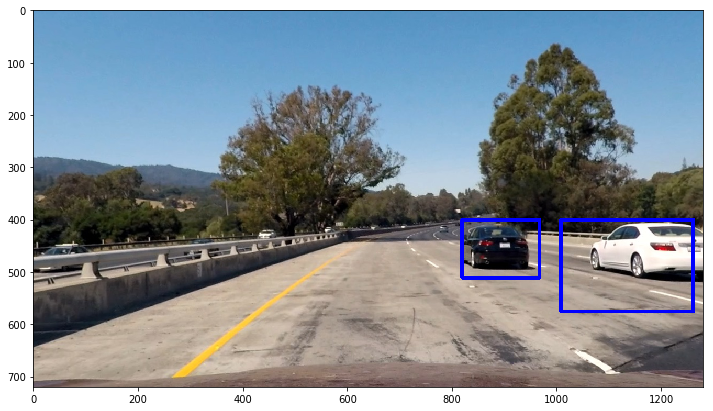

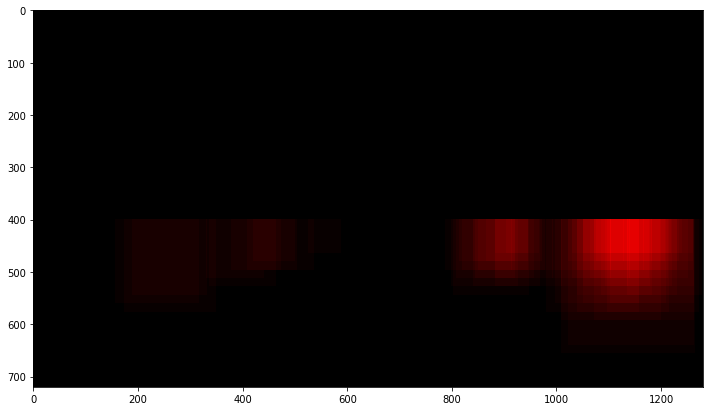

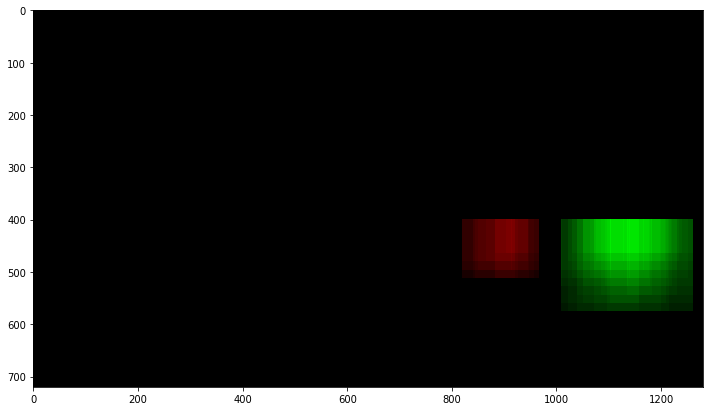

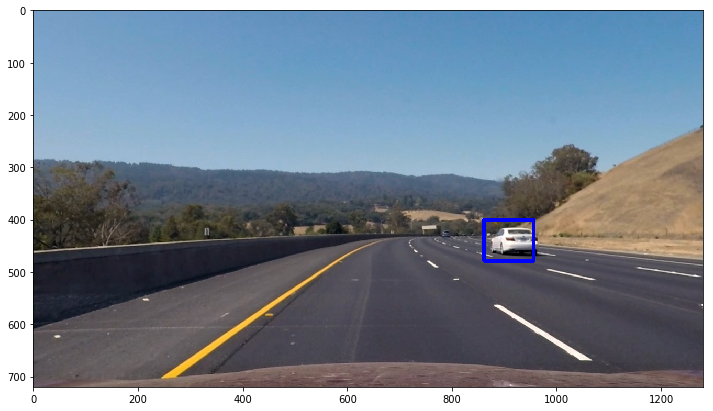

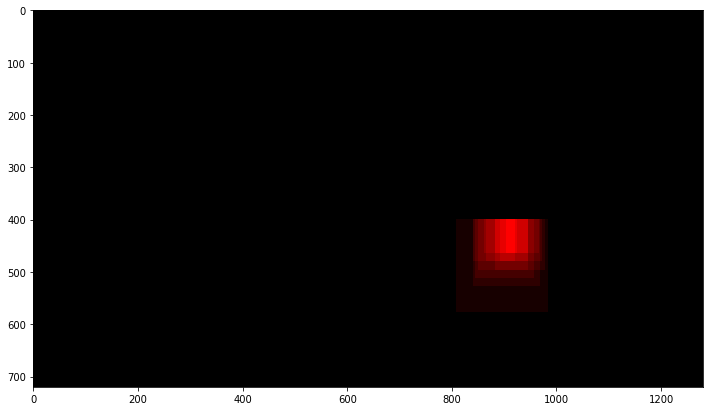

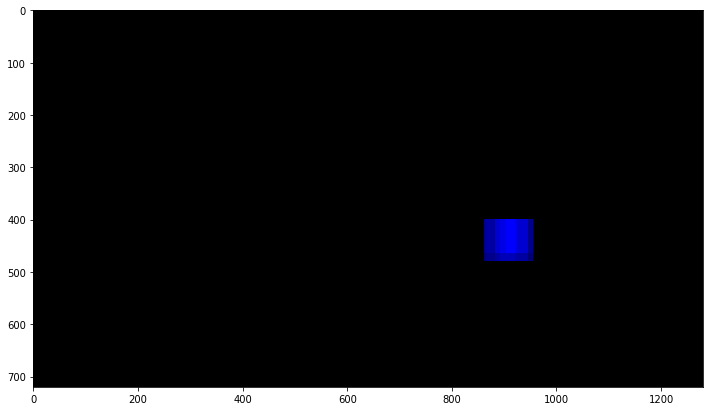

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


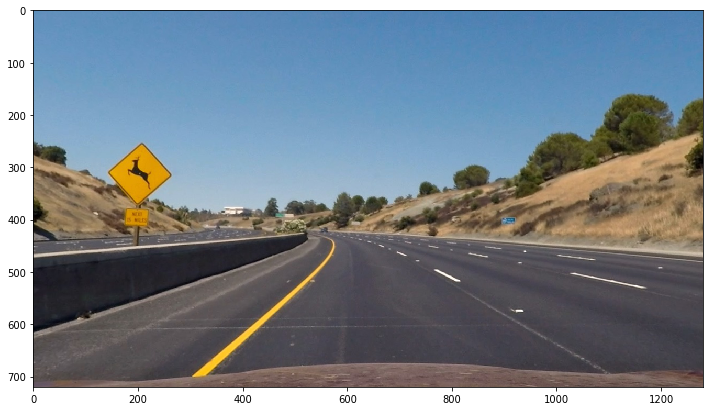

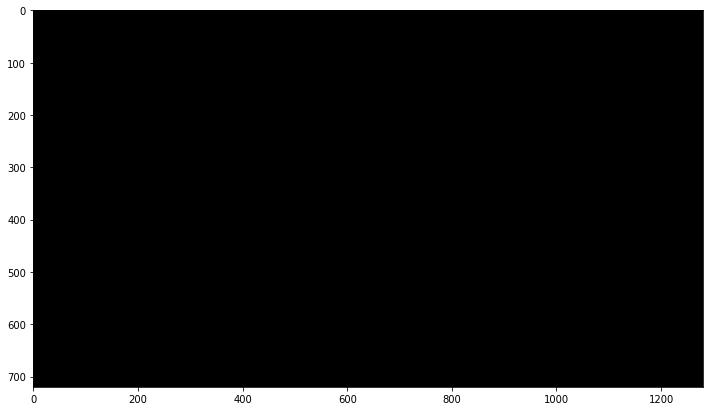

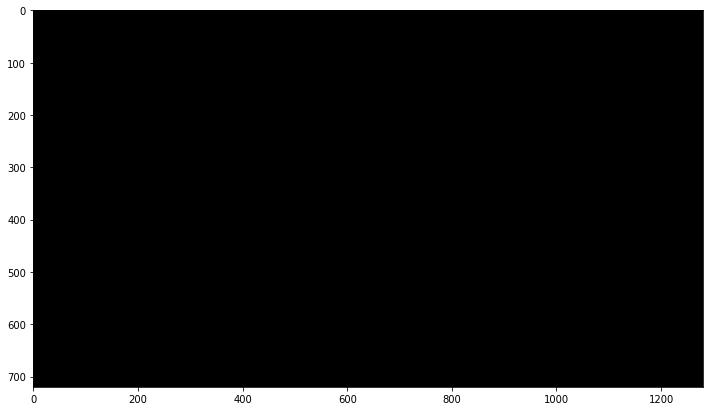

In [8]:
for img_path in glob.glob('test_images/*.jpg'):
    try:
        # img_path = "/Users/anil_choudhary/src/self/udacity/SDC/CarND-Vehicle-Detection/output_images/%d.png" % i
        img = mpimg.imread(img_path)
        res, res2, res_heatmap = predict(img)
        plt.figure(figsize=(12,24))
        plt.imshow(res)
        plt.show();
        plt.figure(figsize=(12,24))
        plt.imshow(res2)
        plt.show();
        plt.figure(figsize=(12,24))
        plt.imshow(res_heatmap)
        plt.show();
    except:
        pass

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# white_output = "./project_video_cars2.mp4"

# clip1 = VideoFileClip('project_video.mp4')
# white_clip = clip1.fl_image(predict)
# %time white_clip.write_videofile(white_output, audio=False)

In [ ]:
def sliding_window(img_orig):
    img_result = img_orig.copy()
    heatmap = np.zeros(img_orig.shape[:2], np.uint8)
    
    START_X, END_X = 400, 680
    START_Y, END_Y = 0, 1280
    
    img = img_orig[START_X: END_X, :, :]
    img = np.float32(1. * img / img.reshape(-1,3).max(axis=0))
    
    WINDOW_SIZE_MIN = 64
    WINDOW_SIZE_MAX = END_X - START_X
    WINDOW_SIZE_STEP = 16
    
    PIXELS_PER_CELL = 8
    CELLS_PER_BLOCK = 3
    
    EPSILON = 1e-5
    
    IMG_CLF_SIZE = 64
    IMG_CLF_SHAPE = (IMG_CLF_SIZE, IMG_CLF_SIZE)

    # iterate over incrementally large slices of images from vehicles
    # further away, to those nearer to us
    lst_max = []
    lst_max2 = []
    for window_size in np.arange(WINDOW_SIZE_MIN, WINDOW_SIZE_MAX+1, WINDOW_SIZE_STEP):
        
        img_slice = img[:window_size, :]

        # re-scale image
        scaling_factor = 1.0 * IMG_CLF_SIZE / window_size
        img_scaled = cv2.resize(img_slice, (0,0), 
                                fx=scaling_factor, 
                                fy=scaling_factor)

        # number of windows
        window_slide_step_y_scaled = int(1./3 * window_size * scaling_factor)
        n_window_y = (img_scaled.shape[1] - IMG_CLF_SIZE) // window_slide_step_y_scaled + 1

        for i in np.arange(n_window_y):
            window_start_x = 0
            window_end_x   = IMG_CLF_SIZE
            window_start_y = int(i * window_slide_step_y_scaled)
            window_end_y   = int(i * window_slide_step_y_scaled) + IMG_CLF_SIZE
            
            window_unscaled_start_x = int(window_start_x / scaling_factor)
            window_unscaled_end_x = int(window_end_x / scaling_factor)

            window_unscaled_start_y = int(window_start_y / scaling_factor)
            window_unscaled_end_y = int(window_end_y / scaling_factor)

            pt1 = (START_Y+window_unscaled_start_y, START_X+window_unscaled_start_x)
            pt2 = (START_Y+window_unscaled_end_y, START_X+window_unscaled_end_x) 
            
            img_result = cv2.rectangle(img_result, pt1, pt2, (0,0,255), 3)

    return img_result

In [9]:
plt.figure(figsize=(12,24))
plt.imshow(sliding_window(mpimg.imread('/Users/anil_choudhary/src/self/udacity/SDC/CarND-Vehicle-Detection/output_images/350.png')[:,:,:3]))
plt.show()

NameError: name 'sliding_window' is not defined

<Figure size 864x1728 with 0 Axes>